# Taking a quick look on the data

The objective is to quickly gather a series of information on the data we are looking at

In [1]:
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from anytree import Node, RenderTree
from typing import Dict, List

plt.style.use('ggplot')

What are the shapes of the data we are working? 
- We are assuming (30000, 31) for train data and (300, 1259) for target data
- Since test dataset is not labeled we will most likely use a test set and dev set taken from the training set. Selected data should be taken with a specific sampling technique that we will discuss later

In [2]:
training_dataset = './data/train_data/*'
test_dataset = './data/test_data/*'


# Access training ids
training_paths_raw = glob(training_dataset)
training_ids_raw = [path.split('/')[-1] for path in training_paths_raw]
training_ids_raw = [path.split('\\')[-1] for path in training_ids_raw]

# Access test ids
test_paths = glob(test_dataset)
test_ids = [path.split('/')[-1] for path in test_paths]
test_ids = [path.split('\\')[-1] for path in test_ids]

print(f'We are working with {len(training_ids_raw)} training examples')
print(f'We are working with {len(test_ids)} test examples')



We are working with 2000 training examples
We are working with 150 test examples


Let us take a look on what is inside each id

In [3]:
training_sample = os.listdir(training_paths_raw[0])
training_sample

['receiver_data_src_1.npy',
 'receiver_data_src_150.npy',
 'receiver_data_src_225.npy',
 'receiver_data_src_300.npy',
 'receiver_data_src_75.npy',
 'vp_model.npy']

--- 
Let us confirm all data has the appropiate shape

In [4]:
for i in range(len(training_paths_raw)):
    assert np.load(os.path.join(training_paths_raw[i], f'receiver_data_src_1.npy')).shape == (10001, 31)
    assert np.load(os.path.join(training_paths_raw[i], f'receiver_data_src_75.npy')).shape == (10001, 31)
    assert np.load(os.path.join(training_paths_raw[i], f'receiver_data_src_150.npy')).shape == (10001, 31)
    assert np.load(os.path.join(training_paths_raw[i], f'receiver_data_src_225.npy')).shape == (10001, 31)
    assert np.load(os.path.join(training_paths_raw[i], f'receiver_data_src_300.npy')).shape == (10001, 31)
    assert np.load(os.path.join(training_paths_raw[i], f'vp_model.npy')).shape == (300, 1259)

In [5]:
RECEIVER_SHAPE = (10001, 31)
VP_MODEL_SHAPE = (300, 1259)

---
Let us find out the data type of every file


In [6]:
training_sample = np.load(os.path.join(training_paths_raw[0], f'receiver_data_src_1.npy'))
target_sample = np.load(os.path.join(training_paths_raw[0], f'vp_model.npy'))
print(f'The dtype of a training instance is: {training_sample.dtype}')
print(f'The dtype of a training label is: {target_sample.dtype}')

The dtype of a training instance is: float32
The dtype of a training label is: float64


Training instances are single float precision, while labels are expected to be double float precision

---
Before comencing exploratory data analysis we must decide strategy on train/test split <br>
While ThinkOnward provides test and train data I will try to engage in a different strategy that will allow us a much easier understanding of the model performance 

---

## Train Test Split

As said before we are working with 2000 training examples and 150 test examples. With this in mind we will follow the next strategy:

- Choosing an split ratio on the training set
- Picking a random seed so our results can be reproducible
- Shuffle our training indices
- Partition into train/validation set
- Sanity check

What are the possible problems with this approach? <br>
- If the dataset gets updated, then the solution will be broken since we will have a new mix of train/validation instances.
- Prone to sampling bias if the chosen validation examples are not representative of the whole training examples.



In [7]:
# Split ratio: 
# 80% -> Training set
# 20% -> Validation set
import numpy as np

def shuffle_and_split_data(data, val_ratio):
    """
    Shuffles a list of folder paths and splits it into training and validation subsets.

    Parameters
    ----------
    data : list of str
        List of folder paths, where each folder contains data samples for training or validation.
    
    val_ratio : float
        The proportion of the data to allocate to the validation set. Must be between 0 and 1.

    Returns
    -------
    train_data : list of str
        Shuffled list of folder paths to be used for training.

    val_data : list of str
        Shuffled list of folder paths to be used for validation.

    Notes
    -----
    A fixed random seed (18) is used for reproducibility.
    """
    np.random.seed(18)
    shuffled_indices = np.random.permutation(len(data))
    val_set_size = int(len(data) * val_ratio)
    val_indices = shuffled_indices[:val_set_size]
    train_indices = shuffled_indices[val_set_size:]
    return  [data[i] for i in train_indices], [data[i] for i in val_indices]

training_ids, validation_ids = shuffle_and_split_data(training_ids_raw, 0.2)


---
Now we need to run a sanity check to see if our approach did not sample bias the train set

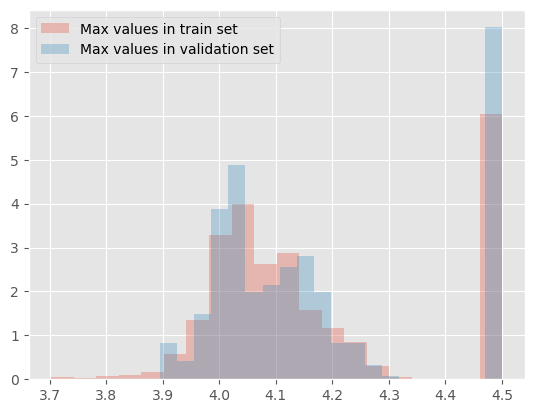

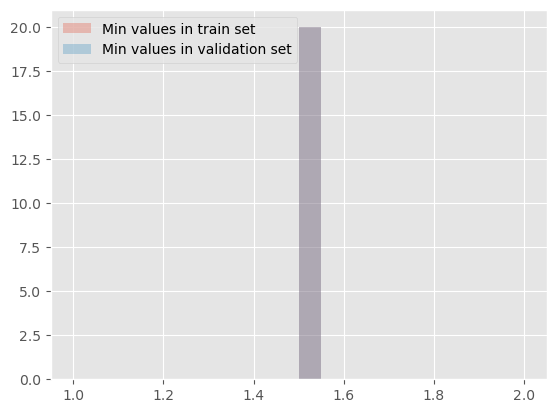

In [8]:
# First we will compute a histogram of our maximum values within each vp_model in the training set vs the validation set
#target_sample = np.load(os.path.join(training_paths_raw[0], f'vp_model.npy'))

def compute_max_velocity(data):
    values = [np.load(f'./data/train_data/{id}/vp_model.npy').max() for id in data]
    return values

def compute_min_velocity(data):
    values = [np.load(f'./data/train_data/{id}/vp_model.npy').min() for id in data]
    return values

def compare_histograms(values: dict, num_bins: int):
    kwargs = dict(histtype = 'stepfilled', alpha = 0.3, density = True, bins = num_bins)
    for title, val in zip(values.keys(), values.values()):
        plt.hist(val, **kwargs, label=title);
    plt.legend()
    plt.show()

        

max_values_train_set = compute_max_velocity(training_ids)
max_values_val_set = compute_max_velocity(validation_ids)

min_values_train_set = compute_min_velocity(training_ids)
min_values_val_set = compute_min_velocity(validation_ids)

compare_histograms(values = {'Max values in train set': max_values_train_set, 'Max values in validation set': max_values_val_set}, num_bins=20)
compare_histograms(values = {'Min values in train set': min_values_train_set, 'Min values in validation set': min_values_val_set}, num_bins=20)



We can observe that the random split did not introduce any skewness to the data, and both histograms containing min and max values look similar. We can confidently move forward with this train/val split. <br>

What can we improve?
- Compare the mean and standard deviation and compare distributions
- Approximate finite differences and compute a mean absolute gradient per split
- For each shot calculate RMS amplitude and compare train/val histograms
- **Peak amplitude, I Believe this is worth persuing**: Track max(|d|) per gather. If val has far higher peaks, it may represent stronger reflections (i.e. different geology).
- Kolmogorov-Smirnov on mean vp

---

## Exploratory Data Analysis

We will now work with a copy of the training split to try to find out more information about the data <br>
Our strategy for this section:
1. Univariate summaries:
    - Shot-Gather inputs
        - Mean, standard deviation, RMS, skewness and kurtosis across all time-reciever samples in order to reveal overall signal strength, noise levels and outliers
        - Compute the analytic signal envelope per gather to see where energy is concentrated in time (early vs late arrivals)
        - FFT of individual traces
    - Velocity-Model Targets
        - Histograms of vp values in order to tell typical velocity ranges (sediment vs. basement)
        - Spatial gradients
        - Aucorrelation lengths and variogram analysis horizontally and vertically
2. Bivariate and Correlation Analysis:
    - Input vs Target correlation:
        - Rms amplitude correlation with global vp statistics, with the hope of finding insights on amplitude and high velocity zones
    - Cross-plot:
        - For all samples scatter mean shot frequency against model gradient
3. Spacial and Image-Based exploration:
    - Shot-Gather:
        - Common-Midpoint (CMP) fold
    - Velocity Maps:
        - Layer slicing
        - Vertical cross-sections
4. Multivariate & Dimensionality reduction:
    - PCA on descriptors, compute descriptors for each sample and embed in 2D, with the hope of clustering and finding natural groupings
    - Clustering on those descriptors and defining 'prototypes' of geological scenarios, if done we need to ensure to represent these clusters well in train/validation split
5. Geophysical-Specific Attributes:
    - Semblance Analysis:
        - Semblance panels on synthetic gathers, looking for a high semblance to indciate coherent reflectors
        - Compare against known layer tops in vp to validate my forward modeling
    - First-break picking:
        - Automatically pick first arrivals and build a simple time-depth curve, inversion should honor the curve so it is useful as a sanity check
    - Fault & Anomaly detection:
        - Run Sobel edge-detection on vp maps to highlight velocity discontinuities
        - Check against known faultsin the synthetic models


---
1. Univariate summaries <br>
 Shot-gather inputs

- Mean, standard deviation, RMS, skewness and kurtosis across all time-reciever samples in order to reveal overall signal strength, noise levels and outliers

In [9]:
# New approach using only 2 numpy array and invoking different axes for disctinct operations
# One array contains all information regarding inputs, while the other contains the labels
def load_data_array(sample_ids: list, receiver_ids: list = [1, 75, 150, 225, 300], receiver_shape: tuple = (10001, 31), model_shape: tuple = (300, 1259)):
    """
    Loads seismic input data and corresponding velocity model labels into NumPy arrays.

    Parameters
    ----------
    sample_ids : list of str
        List of sample IDs to load (each corresponding to a folder under ./data/train_data/).

    receiver_ids : list of int, optional
        List of source positions to load seismic data from. Each ID corresponds to a file named
        'receiver_data_src_{id}.npy'. Default is [1, 75, 150, 225, 300].

    receiver_shape : tuple of int, optional
        Expected shape of each individual receiver data file. Default is (10001, 31), where
        10001 is the number of time steps and 31 is the number of receivers.

    model_shape : tuple of int, optional
        Shape of the velocity model (label) per sample. Default is (300, 1259), where
        300 is the horizontal axis and 1259 is the depth axis.

    Returns
    -------
    data : np.ndarray
        Array of shape (num_samples, num_receivers, time_steps, num_channels) containing seismic input data.

    labels : np.ndarray
        Array of shape (num_samples, model_shape[0], model_shape[1]) containing velocity model labels.

    Notes
    -----
    This function assumes that the directory structure follows:
        ./data/train_data/{sample_id}/receiver_data_src_{receiver_id}.npy
        ./data/train_data/{sample_id}/vp_model.npy
    and that all files exist and match the expected shape.
    """
    
    num_samples = len(sample_ids)
    num_receivers = len(receiver_ids)

    result = np.zeros((num_samples, num_receivers, receiver_shape[0], receiver_shape[1]), dtype=np.float32)
    result2 = np.zeros((num_samples, model_shape[0], model_shape[1]))

    for i, sample_id in enumerate(sample_ids):
        for j, receiver_id in enumerate(receiver_ids):
            arr = np.load(f'./data/train_data/{sample_id}/receiver_data_src_{receiver_id}.npy')
            arr2 = np.load(f'./data/train_data/{sample_id}/vp_model.npy')
            result[i, j, :, :] = arr
            result2[i, :, :] = arr2
    return result, result2

data, labels = load_data_array(sample_ids=training_ids[:160])

In [10]:
print(f'The loaded data has shape: {data.shape} \n{data.shape[0]} is the number of samples\n{data.shape[1]} is the shot\n{data.shape[2]} is the time\n{data.shape[3]} is the receiver')

The loaded data has shape: (160, 5, 10001, 31) 
160 is the number of samples
5 is the shot
10001 is the time
31 is the receiver


In [11]:
def compute_global_metrics(data):
    """
    Computes global statistical metrics (mean, standard deviation, and RMS) across all samples, 
    along with their skewness and kurtosis.

    Parameters
    ----------
    data : np.ndarray
        A 4D NumPy array of shape (num_samples, num_receivers, time_steps, channels), where:
        - axis 0: sample index
        - axis 1: receiver/source index
        - axis 2: time steps
        - axis 3: receivers or channels

    Returns
    -------
    mean_metrics : tuple
        A tuple containing:
        - overall_mean_values : np.ndarray of shape (num_samples,)
            Mean amplitude per sample.
        - mean_skew : float
            Skewness of the sample-wise mean values.
        - mean_kurtosis : float
            Kurtosis of the sample-wise mean values.

    std_metrics : tuple
        A tuple containing:
        - overall_standard_deviation_values : np.ndarray of shape (num_samples,)
            Standard deviation per sample.
        - std_skew : float
            Skewness of the sample-wise standard deviation values.
        - std_kurtosis : float
            Kurtosis of the sample-wise standard deviation values.

    rms_metrics : tuple
        A tuple containing:
        - overall_rms_values : np.ndarray of shape (num_samples,)
            Root mean square amplitude per sample.
        - rms_skew : float
            Skewness of the sample-wise RMS values.
        - rms_kurtosis : float
            Kurtosis of the sample-wise RMS values.

    Notes
    -----
    - This function computes metrics sample-wise by collapsing the last three axes.
    - Skewness and kurtosis are computed using `scipy.stats`.
    - Full computation may take several minutes depending on dataset size (~6 minutes for large datasets).
    """
    from scipy.stats import skew, kurtosis

    overall_mean_values = data.mean(axis=(1,2,3))
    overall_standard_deviation_values = data.std(axis=(1,2,3))
    overall_rms_values = np.sqrt((data**2).mean(axis = (1,2,3)))

    mean_skew = skew(overall_mean_values)
    std_skew = skew(overall_standard_deviation_values)
    rms_skew = skew(overall_rms_values)

    mean_kurtosis = kurtosis(overall_mean_values)
    std_kurtosis = kurtosis(overall_standard_deviation_values)
    rms_kurtosis = kurtosis(overall_rms_values)

    return (overall_mean_values, mean_skew, mean_kurtosis), (overall_standard_deviation_values, std_skew, std_kurtosis), (overall_rms_values, rms_skew, rms_kurtosis)

In [20]:
global_mean_values, global_std_values, global_rms_values = compute_global_metrics(data) 
global_mean, global_mean_skew, global_mean_kurtosis = global_mean_values
global_std, global_std_skew, global_std_kurtosis = global_std_values
global_rms, global_rms_skew, global_rms_kurtosis = global_rms_values

print(global_rms_kurtosis)
print(global_std_kurtosis)

print(global_rms_skew)
print(global_std_skew)

39.88380634062407
39.88092852390615
5.39345430000816
5.393051065394949


In [13]:
import matplotlib.pyplot as plt

def compute_global_histograms(values: dict, num_bins: int, skew, kurtosis):
    """
    Plots overlaid histograms of given value distributions, with skewness and kurtosis annotated.

    Parameters
    ----------
    values : dict
        Dictionary where keys are labels (e.g. 'Mean', 'Std Dev', 'RMS') and values are 1D NumPy arrays.
    num_bins : int
        Number of bins for the histogram.
    skew : float
        Skewness value to annotate.
    kurtosis : float
        Kurtosis value to annotate.
    """
    kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=num_bins)
    textstr = f"Skewness: {skew:.2f}\nKurtosis: {kurtosis:.2f}"
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)

    fig, ax = plt.subplots(figsize=(8, 4))
    for title, val in values.items():
        ax.hist(val, **kwargs, label=title)

    ax.text(0.95, 0.75, textstr, transform=ax.transAxes,
            fontsize=12, verticalalignment='top', horizontalalignment='right',
            bbox=props)

    ax.set_title("Global Distributions")
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.legend()
    plt.tight_layout()
    plt.show()

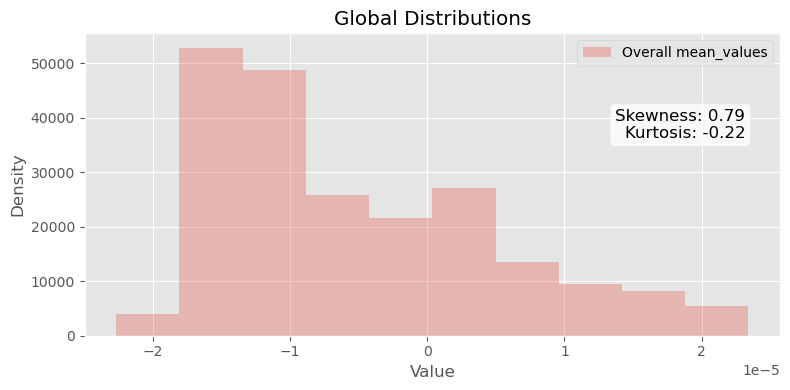

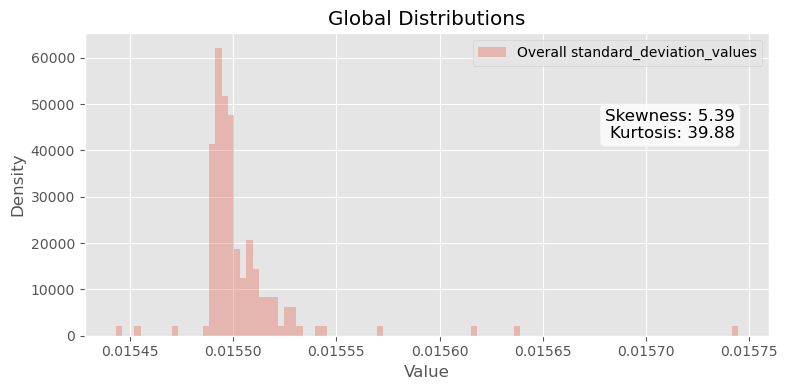

In [22]:
compute_global_histograms(values = {'Overall mean_values': global_mean}, num_bins=10,skew= global_mean_skew, kurtosis=global_mean_kurtosis)
compute_global_histograms(values = {'Overall standard_deviation_values': global_std}, num_bins=100, skew = global_std_skew, kurtosis=global_std_kurtosis )

- Compute the analytic signal envelope per gather to see where energy is concentrated in time (early vs late arrivals)


---

In [15]:
def compute_shot_metrics(data):
    per_shot_mean_values = data.mean(axis = (2, 3))
    per_shot_std_values = data.std(axis= (2, 3))
    per_shot_rms_values = np.sqrt((data**2).mean(axis = (2, 3)))

    return per_shot_mean_values, per_shot_std_values, per_shot_rms_values

shot_mean, shot_std, shot_rms = compute_shot_metrics(data)
shot_mean.shape

(160, 5)

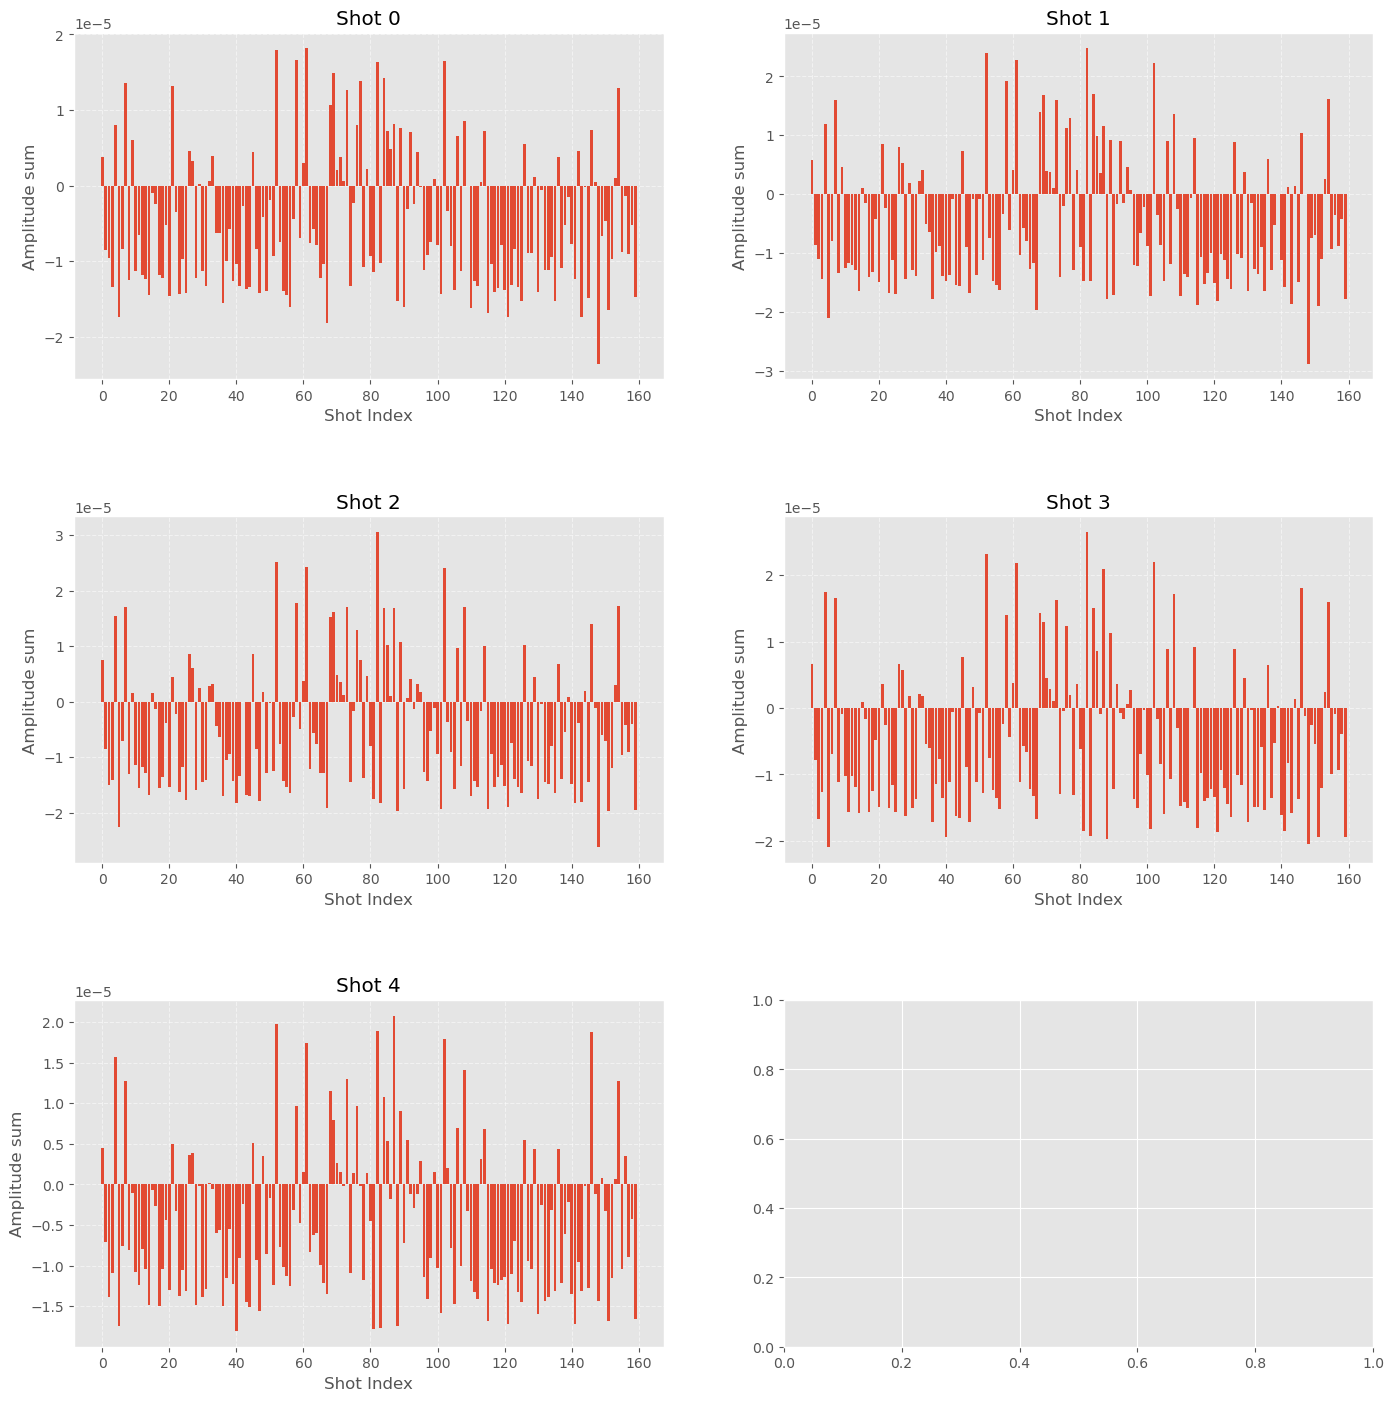

In [23]:
def compute_shot_metrics(data):
    # Computation of metrics
    n_samples, n_shots = data.shape

    fig, axs = plt.subplots(3,2, figsize = (15, 15))
    axs = axs.flatten()

    for shot in range(min(n_shots, len(axs))):
        shot_data = data[:, shot]
        axs[shot].grid(True, linestyle='--', alpha=0.5)
        fig.tight_layout(pad=5.0)

        axs[shot].bar(range(n_samples), shot_data)
        axs[shot].set_title(f'Shot {shot}')
        axs[shot].set_xlabel(f'Shot Index')
        axs[shot].set_ylabel(f'Amplitude sum')

compute_shot_metrics(shot_mean)
